IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import sklearn.linear_model as lm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE
from itertools import chain, combinations
import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

In [96]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
# display(df.head())
# print("Deleted Duplicate Entries:")
# display(df.loc[df.duplicated(keep=False)])
df.drop_duplicates(inplace=True)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


# Helper Functions

In [2]:
def get_train_score(xtrain, ytrain):
    lr = lm.LinearRegression()
    lr.fit(xtrain, ytrain)
    return lr.score(xtrain, ytrain)

def get_adjusted_train_score(xtrain, ytrain):
    # test R-Squared
    R2 = get_train_score(xtrain,ytrain)
    # number of observations in test data
    n = xtrain.shape[0]
    # number of features in test data (including constant)
    k = xtrain.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def get_test_score(xtrain, ytrain, xtest, ytest):
    lr = lm.LinearRegression()
    lr.fit(xtrain, ytrain)
    return lr.score(xtest, ytest)

# Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]
def get_adjusted_test_score(xtrain, ytrain, xtest, ytest):
    # test R-Squared
    R2 = get_test_score(xtrain,ytrain,xtest,ytest)
    # number of observations in test data
    n = xtest.shape[0]
    # number of features in test data (including constant)
    k = xtest.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def print_test_scores(xtrain, ytrain, xtest, ytest):
    print(f"         Test R2: {get_test_score(xtrain, ytrain, xtest, ytest)}")
    print(f"Test Adjusted R2: {get_test_score(xtrain, ytrain, xtest, ytest)}")

def scale_custom(xtrain, xtest, col_names):
    # normally scale regularly distributed columns
    scaler = StandardScaler()
    custom_xtrain = pd.DataFrame(data=scaler.fit_transform(xtrain.drop(columns=col_names)),
                                 index=xtrain.index,
                                 columns=[col for col in xtrain.columns if col not in col_names])
    custom_xtest = pd.DataFrame(data=scaler.transform(xtest.drop(columns=col_names)),
                                index=xtest.index,
                                columns=[col for col in xtest.columns if col not in col_names])

    # custom scale irregularly distributed columns
    bad_xtrain = xtrain[col_names]
    bad_xtest = xtest[col_names]
    for col in col_names:
        true_xtrain = bad_xtrain.loc[bad_xtrain[col] != 0][col]
        xtrain_true_mean = true_xtrain.mean()
        xtrain_true_std = true_xtrain.std()
        custom_xtrain[col] = bad_xtrain[col].apply(lambda x: 0 if x == 0 else (x - xtrain_true_mean) / xtrain_true_std)
        custom_xtest[col] = bad_xtest[col].apply(lambda x: 0 if x == 0 else (x - xtrain_true_mean) / xtrain_true_std)

    return (custom_xtrain, custom_xtest)
    
def powerset(col_names, num_cols_lower_bound):
    "powerset([1,2,3]) --> (1,2) (1,3) (2,3) (1,2,3)"
    s = list(col_names)
    return list(list(subset) for subset in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)) if len(list(subset)) > num_cols_lower_bound)


# Numeric Correlations to Price

In [35]:
# Only numeric features, no nans, no duplicates
numeric_df = df.select_dtypes([int,float])
# OUTLIER, 1 sqft and 4 bathrooms
numeric_df.drop(index=1549500215, inplace=True)
# drop lat, long which become zipcode
numeric_df.drop(columns=['lat','long'], inplace=True)

# substitute sqft_home
# numeric_df["sqft_home"] = (numeric_df['sqft_above'] + numeric_df['sqft_basement'] + numeric_df['sqft_garage'] + numeric_df['sqft_patio'])
# numeric_df = numeric_df.drop(columns=["sqft_above", "sqft_basement", "sqft_garage", "sqft_patio"])

# fix columns order
bad_cols = ['sqft_basement','sqft_garage', 'sqft_patio','yr_renovated']
reg_cols = [col for col in numeric_df.columns.to_list() if col not in bad_cols]
numeric_df = numeric_df[reg_cols + bad_cols]

numeric_df.head()


display(numeric_df.head())
display(numeric_df.info())
display(numeric_df.describe(percentiles=[.05,.25,.5,.75,.95]))

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_basement,sqft_garage,sqft_patio,yr_renovated
id,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,1180,1969,0,0,40,0
8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1950,1570,0,240,0
1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1956,1580,0,0,0
1604601802,775000.0,3,3.0,2160,1400,2.0,1090,2010,1070,200,270,0
8562780790,592500.0,2,2.0,1120,758,2.0,1120,2012,550,550,30,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30151 entries, 7399300360 to 9557800100
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          30151 non-null  float64
 1   bedrooms       30151 non-null  int64  
 2   bathrooms      30151 non-null  float64
 3   sqft_living    30151 non-null  int64  
 4   sqft_lot       30151 non-null  int64  
 5   floors         30151 non-null  float64
 6   sqft_above     30151 non-null  int64  
 7   yr_built       30151 non-null  int64  
 8   sqft_basement  30151 non-null  int64  
 9   sqft_garage    30151 non-null  int64  
 10  sqft_patio     30151 non-null  int64  
 11  yr_renovated   30151 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 3.0 MB


None

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_basement,sqft_garage,sqft_patio,yr_renovated
count,3.015100e+04,30151.000000,30151.000000,30151.000000,3.015100e+04,30151.000000,30151.000000,30151.000000,30151.000000,30151.000000,30151.000000,30151.000000
mean,1.108006e+06,3.413552,2.334616,2112.478691,1.671464e+04,1.543365,1809.899307,1975.158071,476.026566,330.238334,217.404066,90.934364
std,8.946335e+05,0.981663,0.889511,973.993389,6.036006e+04,0.567618,878.278036,32.065421,579.638258,285.768874,245.310376,416.499347
min,2.736000e+04,0.000000,0.000000,100.000000,4.020000e+02,1.000000,100.000000,1900.000000,0.000000,0.000000,0.000000,0.000000
5%,4.250000e+05,2.000000,1.000000,940.000000,1.196000e+03,1.000000,830.000000,1916.000000,0.000000,0.000000,0.000000,0.000000
25%,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,1953.000000,0.000000,0.000000,40.000000,0.000000
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,1977.000000,0.000000,400.000000,150.000000,0.000000
75%,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,2003.000000,940.000000,510.000000,320.000000,0.000000
95%,2.500000e+06,5.000000,4.000000,3890.000000,4.573800e+04,2.000000,3460.000000,2021.000000,1500.000000,780.000000,680.000000,0.000000
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,2022.000000,8020.000000,3580.000000,4370.000000,2022.000000


### Train - Test Split

In [333]:
# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(numeric_df.drop(columns='price'), numeric_df[['price']], test_size=.25, random_state=42)


In [ ]:
# NO PRICE OUTLIERs Train test split (.75 train, .25 test)
IQR = numeric_df['price'].quantile(.75) - numeric_df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_bound = numeric_df['price'].quantile(.75) + IQR_scaler * IQR
no_outliers_df = numeric_df.loc[numeric_df['price'] < price_outlier_bound]
X_train, X_test, y_train, y_test = train_test_split(no_outliers_df.drop(columns='price'), no_outliers_df[['price']], test_size=.25, random_state=42)

### Test

In [213]:
xtrain, xtest = scale_custom(X_train, X_test, col_names=bad_cols)

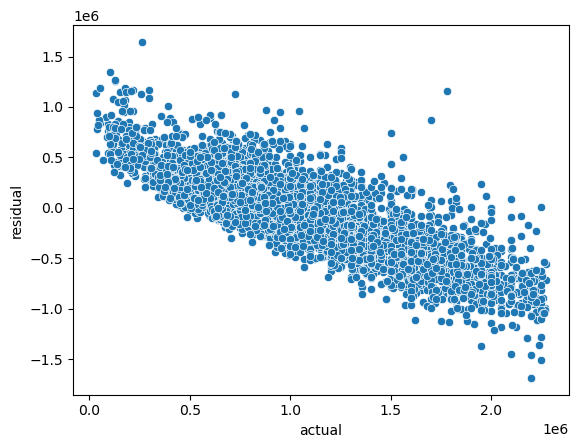

In [201]:
y_hat = lr.predict(xtest)
sns.scatterplot(x= y_test['price'],y= (y_hat - y_test)['price'].to_list()).set(xlabel='actual', ylabel='residual');

### Heatmap

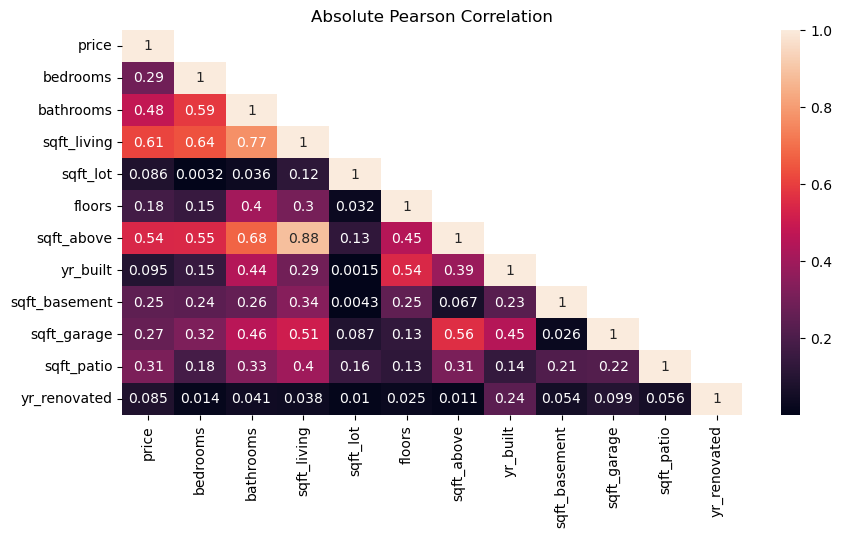

numeric abs(correlation) order: 
sqft_living      0.610040
sqft_above       0.540142
bathrooms        0.481183
sqft_patio       0.313659
bedrooms         0.290017
sqft_garage      0.265311
sqft_basement    0.245532
floors           0.179608
yr_built         0.095408
sqft_lot         0.085952
yr_renovated     0.085088
Name: price, dtype: float64


In [266]:
corr_df = numeric_df.corr().abs()

fig, ax = plt.subplots(figsize=(10,5))

mask = np.triu(np.ones_like(corr_df), k=1)
sns.heatmap(corr_df, annot=True, mask=mask, ax=ax).set(title='Absolute Pearson Correlation')

plt.show()
print("numeric abs(correlation) order: \n{}".format(corr_df['price'].sort_values(ascending=False)[1:]))

### PairPlots

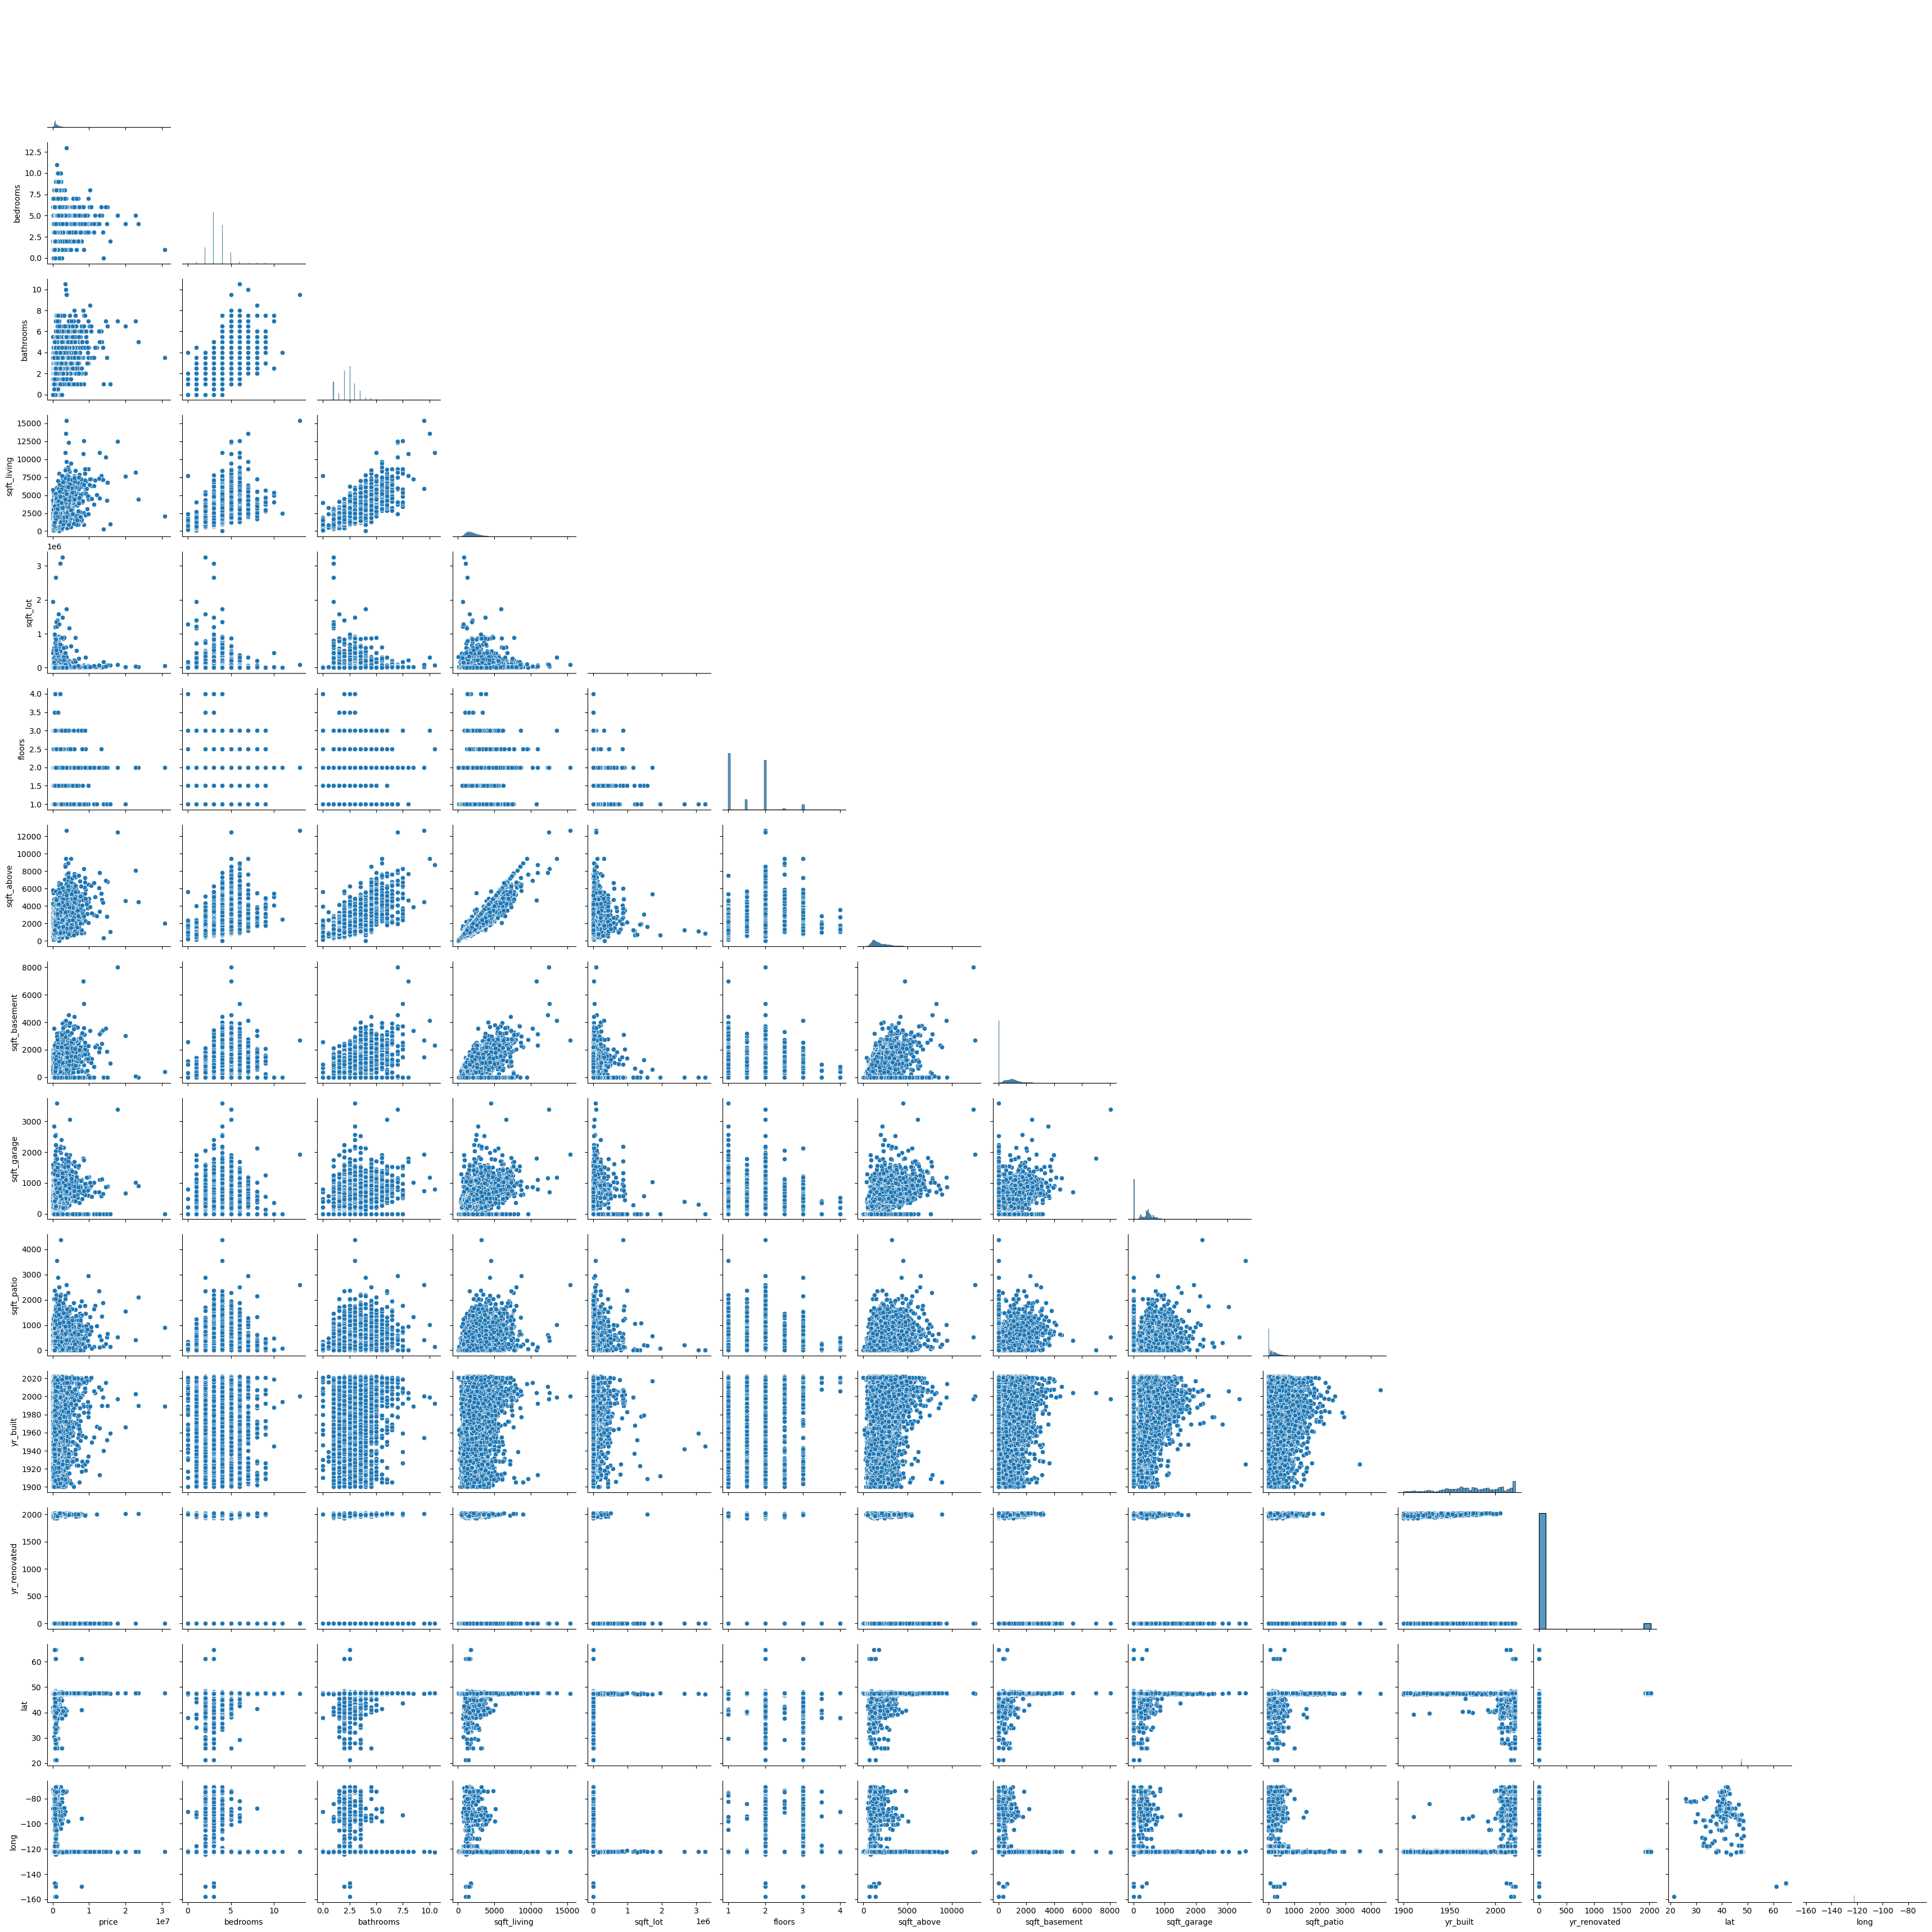

In [7]:
sns.pairplot(numeric_df, corner=True)
plt.show()

### Target Analysis

Target outliers overview
> log_Price and Price_no_outliers, have the most normal-like distributions

price outliers count: 1991


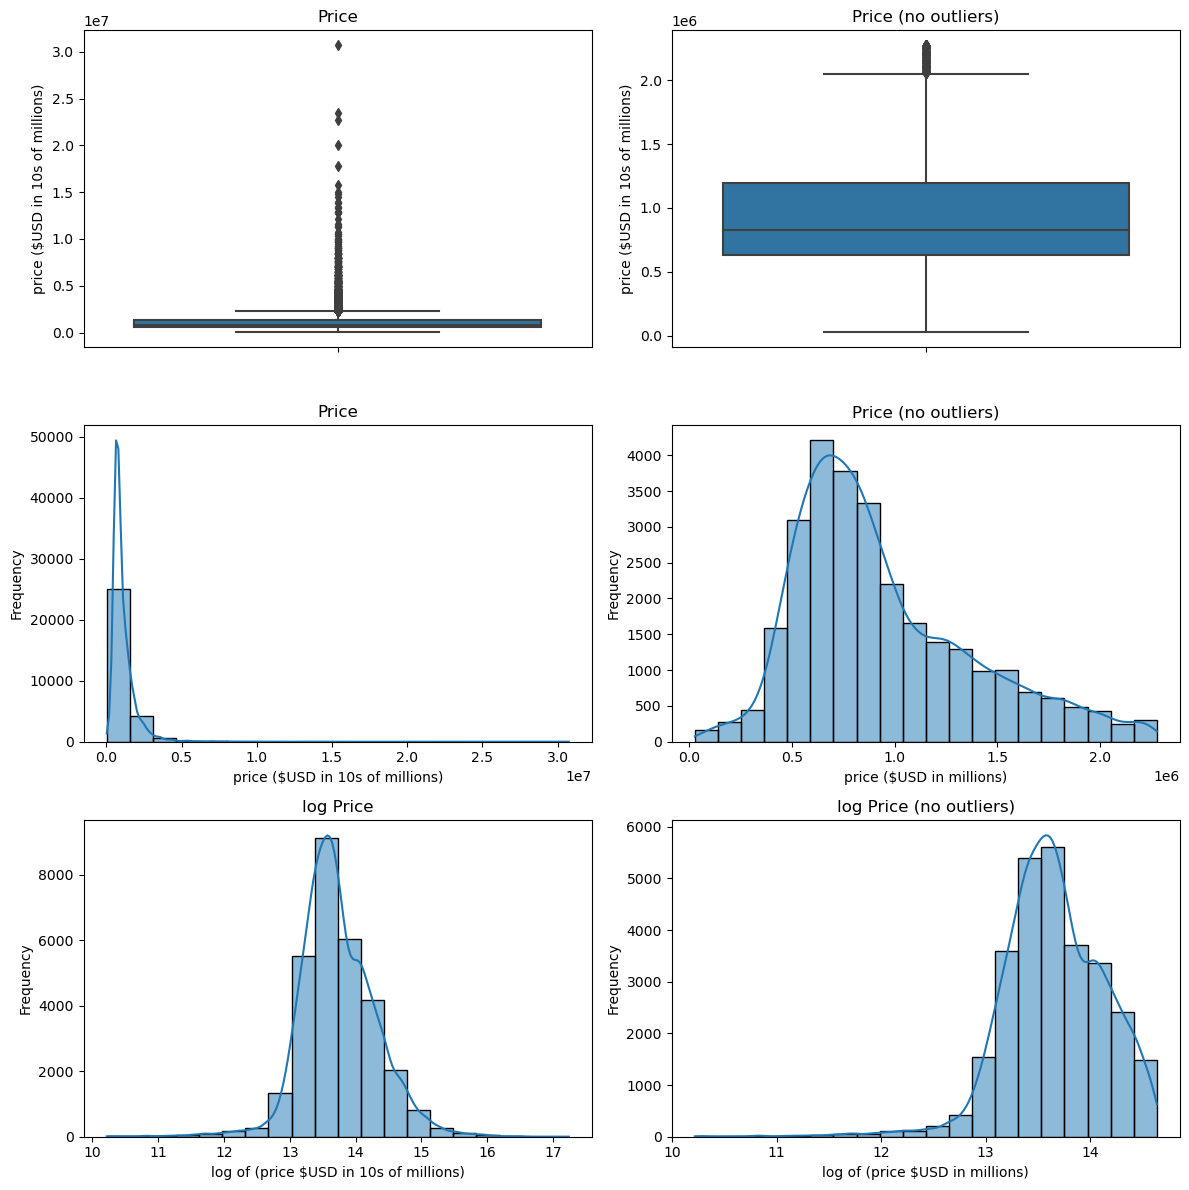

In [158]:
IQR = numeric_df['price'].quantile(.75) - numeric_df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_bound = numeric_df['price'].quantile(.75) + IQR_scaler * IQR
price_no_outliers = numeric_df['price'].loc[numeric_df['price'] < price_outlier_bound]

fig, ax = plt.subplots(3,2, figsize = (12,12))
# boxplot of target
sns.boxplot(y=numeric_df['price'], ax=ax[0][0])
ax[0][0].set_title('Price')
ax[0][0].set_ylabel('price ($USD in 10s of millions)')
ax[0][0].set_xticklabels([])

# boxplot of target - target_outliers
sns.boxplot(y=price_no_outliers, ax=ax[0][1])
ax[0][1].set_title('Price (no outliers)')
ax[0][1].set_ylabel('price ($USD in 10s of millions)')
ax[0][1].set_xticklabels([])

# histogram of target
sns.histplot(numeric_df['price'], bins=20, kde=True, ax=ax[1][0])
ax[1][0].set_title('Price')
ax[1][0].set_ylabel('Frequency')
ax[1][0].set_xlabel('price ($USD in 10s of millions)')

# histogram of target - target_outliers
sns.histplot(price_no_outliers, bins=20, kde=True, ax=ax[1][1])
ax[1][1].set_title('Price (no outliers)')
ax[1][1].set_ylabel('Frequency')
ax[1][1].set_xlabel('price ($USD in millions)')

# histograms of log(target)
sns.histplot(np.log(numeric_df['price']), bins=20, kde=True, ax=ax[2][0])
ax[2][0].set_title('log Price')
ax[2][0].set_ylabel('Frequency')
ax[2][0].set_xlabel('log of (price $USD in 10s of millions)')

# histograms of log(target - target_outliers)
sns.histplot(np.log(price_no_outliers), bins=20, kde=True, ax=ax[2][1])
ax[2][1].set_title('log Price (no outliers)')
ax[2][1].set_ylabel('Frequency')
ax[2][1].set_xlabel('log of (price $USD in millions)')

print('price outliers count: {}'.format(numeric_df.shape[0] - price_no_outliers.shape[0]))
plt.tight_layout()
plt.show()

Target outlier Normality
> Log(Price_no_outliers) is less normally distributed than Price_no_outliers

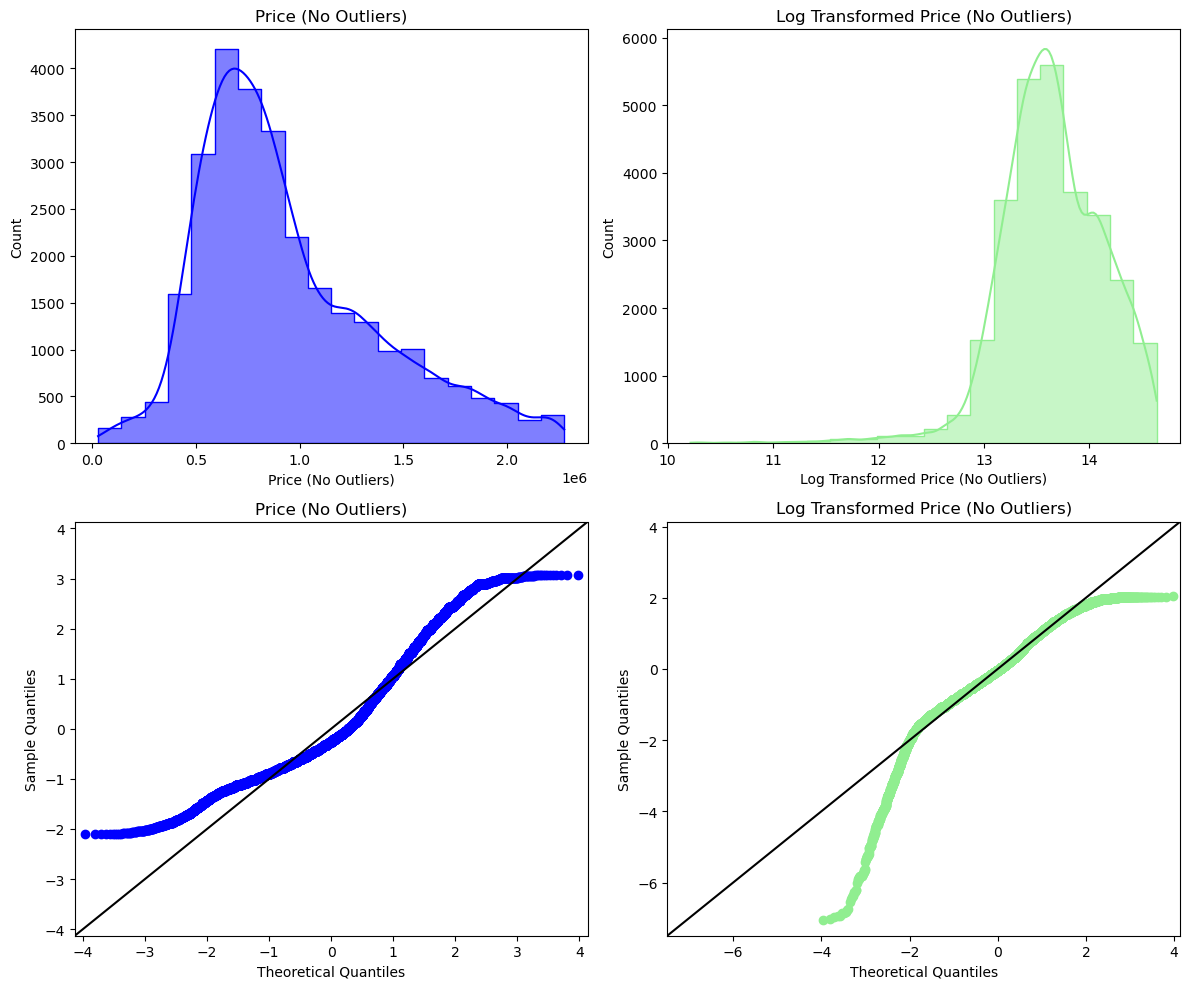

In [159]:
# Compare normality of target_no_outliers vs log_target_no_outliers

# Set up plot and properties of two targets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
targets = [price_no_outliers, np.log(price_no_outliers)]
labels = ["Price (No Outliers)", "Log Transformed Price (No Outliers)"]
colors = ["blue", "lightgreen"]

# Plot histograms
for index, ax in enumerate(axes[0]):
    sns.histplot(targets[index], bins=20, element="step", kde=True, color=colors[index], ax=ax)
    ax.set_xlabel(labels[index])
    ax.set_title(labels[index])
    
# Plot Q-Q plots
for index, ax in enumerate(axes[1]):
    sm.graphics.qqplot(targets[index], dist=stats.norm, line='45', fit=True, ax=ax)
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(colors[index])
    scatter.set_markerfacecolor(colors[index])
    line.set_color("black")
    ax.set_title(labels[index])
    
fig.tight_layout()

Target Normality
> Log(Price) is more normally distributed than Price

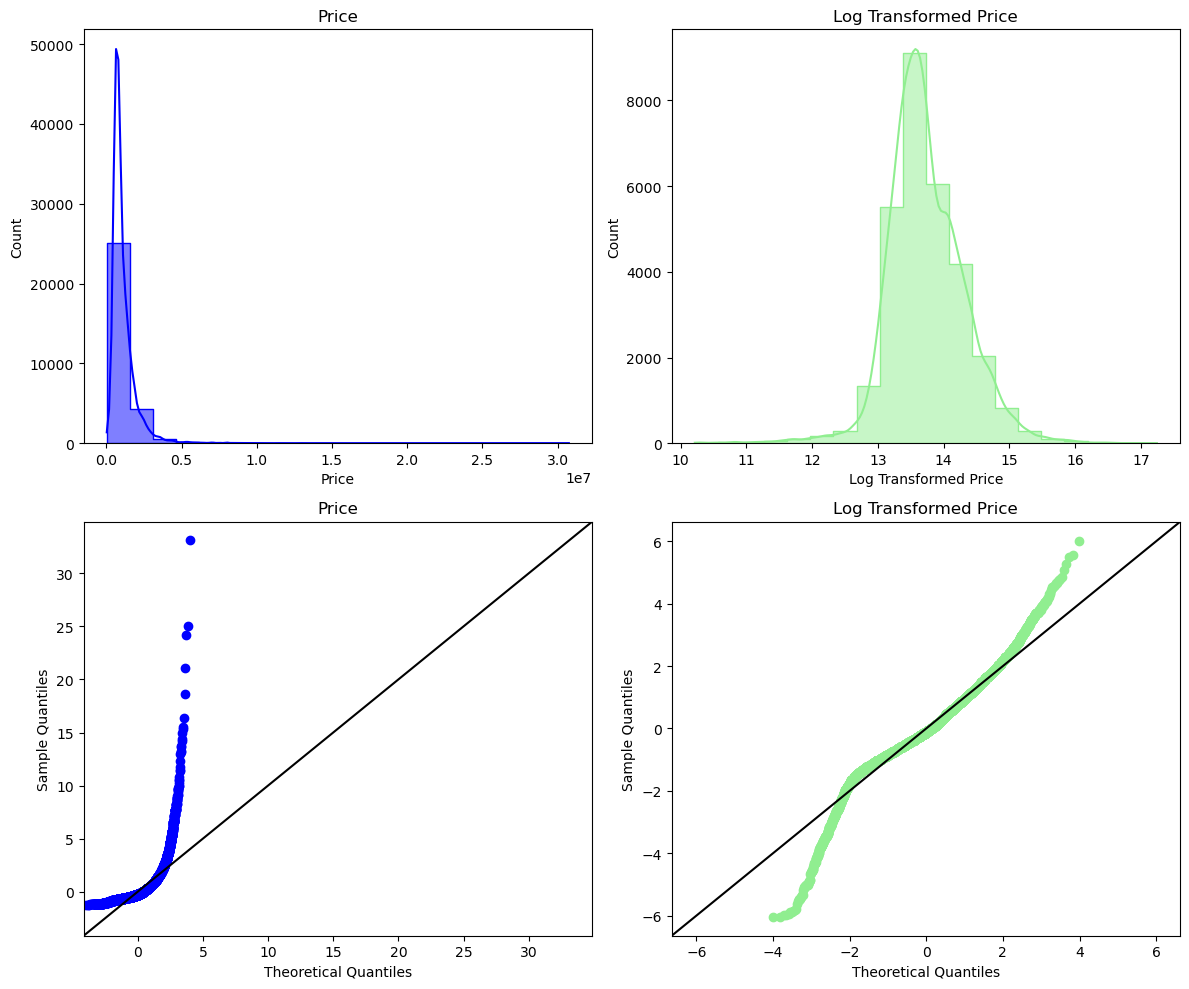

In [160]:
# Compare normality of target vs log_target

# Set up plot and properties of two targets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
targets = [numeric_df['price'], np.log(numeric_df['price'])]
labels = ["Price", "Log Transformed Price"]
colors = ["blue", "lightgreen"]

# Plot histograms
for index, ax in enumerate(axes[0]):
    sns.histplot(targets[index], bins=20, element="step", kde=True, color=colors[index], ax=ax)
    ax.set_xlabel(labels[index])
    ax.set_title(labels[index])
    
# Plot Q-Q plots
for index, ax in enumerate(axes[1]):
    sm.graphics.qqplot(targets[index], dist=stats.norm, line='45', fit=True, ax=ax)
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(colors[index])
    scatter.set_markerfacecolor(colors[index])
    line.set_color("black")
    ax.set_title(labels[index])
    
fig.tight_layout()

### Intercept only model

> STATS  
>
> R2 = 0  
> MAE  = $1,223,166,877,958.95  
> RMSE = $1,223,166,877,959.26  
> MSE  = $1.4961372113366093e+24

In [162]:
# y = y_train, X = mean(y_train) 
y = y_train
X = np.ones(len(y)).reshape(-1,1)

# fit model and display statistics
intercept_only_model = sm.OLS(y,X)
intercept_only_results = intercept_only_model.fit()
intercept_only_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 14 Feb 2023   Prob (F-statistic):                nan
Time:                        15:47:48   Log-Likelihood:            -3.4222e+05
No. Observations:               22614   AIC:                         6.844e+05
Df Residuals:                   22613   BIC:                         6.844e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.106e+06   6007.991    184.083      0.000    1.09e+06    1.12e+06
==============================================================================
Omnibus:                    29672.143   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14077510.865
Skew:                           7.067   Prob(JB):                         0.00
Kurtosis:                     124.411   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
# get MAE, RMSE, and MSE
y_bar = intercept_only_results.params.values[0]
y_hat = intercept_only_results.predict(np.array([y_bar] * len(y_test))).reshape(-1,1)
intercept_only_mae = metrics.mean_absolute_error(y_test, y_hat)
intercept_only_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
intercept_only_mse = metrics.mean_squared_error(y_test, y_hat)
intercept_only_mae, intercept_only_rmse, intercept_only_mse

(1223166877958.955, 1223166877959.263, 1.4961372113366106e+24)

## Feature Normality Comparisons
> scaling feature after log transformation is bad  
> log transformation is more normal than raw feature

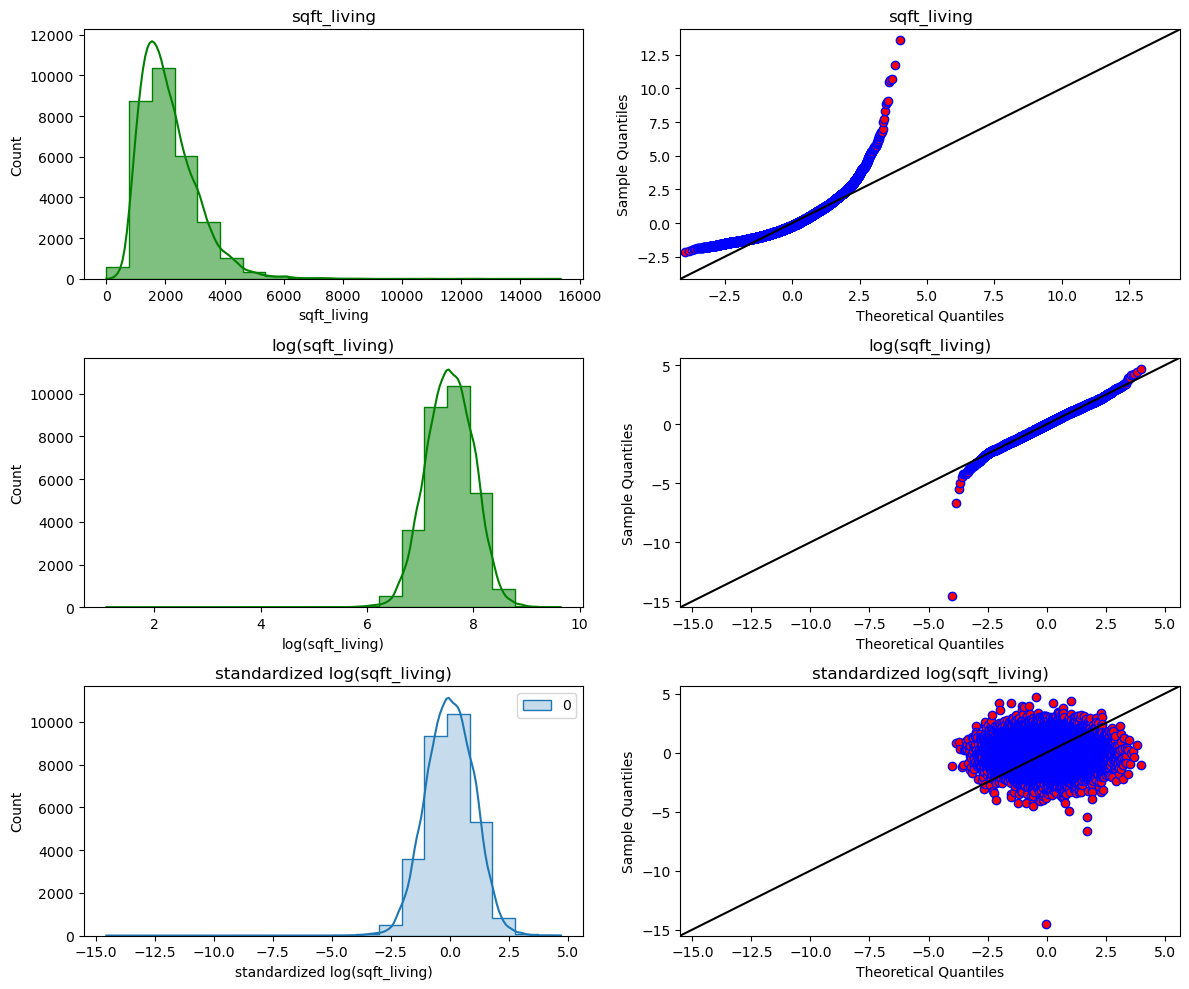

In [164]:
# Compare normality of feature vs log_feature vs scaled_log_feature

# set standard scaler
scaler = StandardScaler()

# Set up plot and properties of two targets
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
targets = [numeric_df['sqft_living'], np.log(numeric_df['sqft_living']), scaler.fit_transform(np.log(numeric_df[['sqft_living']]))]
labels = ['sqft_living','log(sqft_living)','standardized log(sqft_living)']

for index, ax in enumerate(axes):
    #plot histograms
    sns.histplot(targets[index], bins=20, element="step", color='green', kde=True, ax=ax[0])
    ax[0].set_xlabel(labels[index])
    ax[0].set_title(labels[index])

    #plot qq plots
    sm.graphics.qqplot(targets[index], dist=stats.norm, line='45', fit=True, ax=ax[1])
    scatter = ax[1].lines[0]
    line = ax[1].lines[1]
    scatter.set_markeredgecolor('blue')
    scatter.set_markerfacecolor('red')
    line.set_color("black")
    ax[1].set_title(labels[index])
    
fig.tight_layout()

## Baseline Model iterations

### Baseline Model
using `sqft_living` - Square footage of living space in the home

> STATS  
>
> R2 = .357  
> MAE  = $387,075.97  
> RMSE = $660,279.79  
> MSE  = $435,969,410,152.92

In [210]:
# y = training house prices, X = training sqft_living
y = y_train
X = X_train['sqft_living']

# fit model and display statistics
baseline_model = sm.OLS(y,sm.add_constant(X))
baseline_results = baseline_model.fit()
baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.256e+04
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:59:38   Log-Likelihood:            -3.3722e+05
No. Observations:               22614   AIC:                         6.744e+05
Df Residuals:                   22612   BIC:                         6.745e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.084e+04   1.16e+04     -6.131      0.000   -9.35e+04   -4.82e+04
sqft_living   558.4585      4.984    112.056      0.000     548.690     568.227
==============================================================================
Omnibus:                    34088.874   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         46345812.743
Skew:                           8.916   Prob(JB):                         0.00
Kurtosis:                     224.062   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [212]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_results.predict(sm.add_constant(X_test[['sqft_living']])).values.reshape(-1,1)
baseline_mae = metrics.mean_absolute_error(y_test, y_hat)
baseline_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
baseline_mse = metrics.mean_squared_error(y_test, y_hat)
baseline_mae, baseline_rmse, baseline_mse

(387075.9715188813, 660279.7968686641, 435969410152.92426)

### Baseline Model Standardized Feature
using scaled `sqft_living` - Square footage of living space in the home  

> STATS  
>
> R2 = .357  
> MAE  = $387,075.97  
> RMSE = $660,279.79  
> MSE  = $435,969,410,152.92

In [229]:
# Scale train and test feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['sqft_living']])
X_test_scaled = scaler.transform(X_test[['sqft_living']])

# y = training house prices, X = scaled training sqft_living
y = y_train
X = X_train_scaled

# fit model and display statistics
baseline_scaled_model = sm.OLS(y,sm.add_constant(X))
baseline_scaled_results = baseline_scaled_model.fit()
print_test_scores(X,y,X_test_scaled,y_test)
baseline_scaled_results.summary()

         Test R2: 0.3539167706349541
Test Adjusted R2: 0.3539167706349541


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 1.377e+04
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:08:49   Log-Likelihood:            -3.3643e+05
No. Observations:               22613   AIC:                         6.729e+05
Df Residuals:                   22611   BIC:                         6.729e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.107e+06   4654.528    237.779      0.000     1.1e+06    1.12e+06
x1          5.463e+05   4654.528    117.366      0.000    5.37e+05    5.55e+05
==============================================================================
Omnibus:                    28500.573   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11871192.848
Skew:                           6.573   Prob(JB):                         0.00
Kurtosis:                     114.474   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_scaled_results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1)
baseline_scaled_mae = metrics.mean_absolute_error(y_test, y_hat)
baseline_scaled_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
baseline_scaled_mse = metrics.mean_squared_error(y_test, y_hat)
baseline_scaled_mae, baseline_scaled_rmse, baseline_scaled_mse

(387075.9715188815, 660279.7968686641, 435969410152.92426)

### Baseline Model Standardized Feature, Log Transformed Target
using scaled `sqft_living` - Square footage of living space in the home  
using log transformed `price` target

> STATS (BEST)  
>
> R2 = .382  
> MAE  = $387,242.51  
> RMSE = $1,625,341.92  
> MSE  = $2,641,736,364,388.60

In [230]:
# Scale train and test feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['sqft_living']])
X_test_scaled = scaler.transform(X_test[['sqft_living']])

# Log transform train and test target
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

# y = training house prices, X = scaled training sqft_living
y = log_y_train
X = X_train_scaled

# fit model and display statistics
baseline_scaled_logTarget_model = sm.OLS(y,sm.add_constant(X))
baseline_scaled_logTarget_results = baseline_scaled_logTarget_model.fit()
print_test_scores(X,y,X_test_scaled,log_y_test)
baseline_scaled_logTarget_results.summary()

         Test R2: 0.38941723603652967
Test Adjusted R2: 0.38941723603652967


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 1.423e+04
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:09:13   Log-Likelihood:                -14341.
No. Observations:               22613   AIC:                         2.869e+04
Df Residuals:                   22611   BIC:                         2.870e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7333      0.003   4526.292      0.000      13.727      13.739
x1             0.3619      0.003    119.269      0.000       0.356       0.368
==============================================================================
Omnibus:                     4403.908   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35841.441
Skew:                          -0.712   Prob(JB):                         0.00
Kurtosis:                       9.001   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_scaled_logTarget_results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1)
baseline_scaled_logTarget_mae = metrics.mean_absolute_error(np.exp(log_y_test), np.exp(y_hat))
baseline_scaled_logTarget_rmse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat), squared=False)
baseline_scaled_logTarget_mse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat))
baseline_scaled_logTarget_mae, baseline_scaled_logTarget_rmse, baseline_scaled_logTarget_mse

(387242.51256115106, 1625341.922300848, 2641736364388.6157)

### Baseline Model Log Transformed feature
using log transformed `sqft_living` - Square footage of living space in the home  
using raw `price` target

> STATS  
>
> R2 = .254  
> MAE  = $420,664.09  
> RMSE = $723,247.70  
> MSE  = $523,087,240,915.61

In [173]:
# Log transform train and test feature
log_X_train = np.log(X_train[['sqft_living']])
log_X_test = np.log(X_test[['sqft_living']])

# y = training house prices, X = scaled training sqft_living
y = y_train
X = log_X_train

# fit model and display statistics
baseline_logFeature_model = sm.OLS(y,sm.add_constant(X))
baseline_logFeature_results = baseline_logFeature_model.fit()
baseline_logFeature_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     7693.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:47:53   Log-Likelihood:            -3.3890e+05
No. Observations:               22614   AIC:                         6.778e+05
Df Residuals:                   22612   BIC:                         6.778e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.631e+06   8.84e+04    -75.042      0.000    -6.8e+06   -6.46e+06
sqft_living  1.024e+06   1.17e+04     87.709      0.000       1e+06    1.05e+06
==============================================================================
Omnibus:                    33402.960   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33555163.861
Skew:                           8.665   Prob(JB):                         0.00
Kurtosis:                     190.913   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_logFeature_results.predict(sm.add_constant(log_X_test)).values.reshape(-1,1)
baseline_logFeature_mae = metrics.mean_absolute_error(y_test, y_hat)
baseline_logFeature_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
baseline_logFeature_mse = metrics.mean_squared_error(y_test, y_hat)
baseline_logFeature_mae, baseline_logFeature_rmse, baseline_logFeature_mse

(420664.0955920454, 723247.7037057333, 523087240915.6162)

### Baseline Model Log feature & target
using log transformed `sqft_living` - Square footage of living space in the home  
using log transformed `price` target

> STATS  
>
> R2 = .342  
> MAE  = $383,271.51  
> RMSE = $715,707.93  
> MSE  = $512,237,851,498.71

In [175]:
# Log transform train and test feature
log_X_train = np.log(X_train[['sqft_living']])
log_X_test = np.log(X_test[['sqft_living']])

# Log transform train and test target
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

# y = training house prices, X = scaled training sqft_living
y = log_y_train
X = log_X_train

# fit model and display statistics
baseline_logFeatureTarget_model = sm.OLS(y,sm.add_constant(X))
baseline_logFeatureTarget_results = baseline_logFeatureTarget_model.fit()
baseline_logFeatureTarget_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 1.176e+04
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:47:53   Log-Likelihood:                -15101.
No. Observations:               22614   AIC:                         3.021e+04
Df Residuals:                   22612   BIC:                         3.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.9494      0.053    148.790      0.000       7.845       8.054
sqft_living     0.7654      0.007    108.429      0.000       0.752       0.779
==============================================================================
Omnibus:                     3570.269   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39518.297
Skew:                          -0.411   Prob(JB):                         0.00
Kurtosis:                       9.424   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_logFeatureTarget_results.predict(sm.add_constant(log_X_test)).values.reshape(-1,1)
baseline_logFeatureTarget_mae = metrics.mean_absolute_error(np.exp(log_y_test), np.exp(y_hat))
baseline_logFeatureTarget_rmse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat), squared=False)
baseline_logFeatureTarget_mse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat))
baseline_logFeatureTarget_mae, baseline_logFeatureTarget_rmse, baseline_logFeatureTarget_mse

(383271.51683111774, 715707.9372891658, 512237851498.7125)

### NO OUTLIER Baseline Model
testing baseline model after removing target outliers

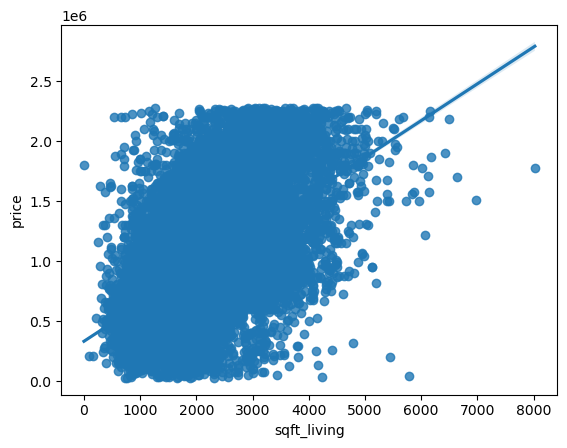

In [177]:
IQR = numeric_df['price'].quantile(.75) - numeric_df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_bound = numeric_df['price'].quantile(.75) + IQR_scaler * IQR
no_outliers_df = numeric_df.loc[numeric_df['price'] < price_outlier_bound]

sns.regplot(x='sqft_living', y='price', data=no_outliers_df, scatter=True);

### NO OUTLIER Baseline Model Standardized Feature, Log Transformed Target
using scaled `sqft_living` - Square footage of living space in the home  
using log transformed `price` target

> STATS  
>
> R2 = .320

In [178]:
# no price outliers test split (.75 train, .25 test)
X_train_trunc, X_test_trunc, y_train_trunc, y_test_trunc = train_test_split(no_outliers_df.drop(columns='price'), 
                                                                            no_outliers_df[['price']], 
                                                                            test_size=.25, 
                                                                            random_state=42)

In [179]:
# Scale train and test feature
scaler = StandardScaler()
X_train_trunc_scaled = scaler.fit_transform(X_train_trunc[['sqft_living']])
X_test_trunc_scaled = scaler.transform(X_test[['sqft_living']])

# y = training house prices, X = scaled training sqft_living
y = y_train_trunc
X = X_train_trunc_scaled

# fit model and display statistics
baseline_trunc_scaled_model = sm.OLS(y,sm.add_constant(X))
baseline_trunc_scaled_results = baseline_trunc_scaled_model.fit()
baseline_trunc_scaled_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     9946.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:47:56   Log-Likelihood:            -3.0012e+05
No. Observations:               21120   AIC:                         6.002e+05
Df Residuals:                   21118   BIC:                         6.003e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.436e+05   2470.435    381.956      0.000    9.39e+05    9.48e+05
x1          2.464e+05   2470.435     99.730      0.000    2.42e+05    2.51e+05
==============================================================================
Omnibus:                     1111.265   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1408.160
Skew:                           0.528   Prob(JB):                    1.67e-306
Kurtosis:                       3.696   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# R2 vs Mean Error

In [180]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
ss = StandardScaler()


print("sqft_living v price")
lr.fit(X_train[['sqft_living']], y_train)
print("Train R2: ",lr.score(X_train[['sqft_living']], y_train))
print("Test R2: ",lr.score(X_test[['sqft_living']], y_test))
print("MAE: ", metrics.mean_absolute_error(y_test, lr.predict(X_test[['sqft_living']])))
print()

print("scaled(sqft_living) v price")
lr.fit(ss.fit_transform(X_train[['sqft_living']]).reshape(-1,1), y_train)
print("Train R2: ",lr.score(ss.transform(X_train[['sqft_living']]), y_train))
print("Test R2: ",lr.score(ss.transform(X_test[['sqft_living']]).reshape(-1,1), y_test))
print("MAE: ", metrics.mean_absolute_error(y_test, lr.predict(ss.transform(X_test[['sqft_living']]).reshape(-1,1))))
print()

print("sqft_living v log(price)")
lr.fit(X_train[['sqft_living']], np.log(y_train))
print("Train R2: ",lr.score(X_train[['sqft_living']], np.log(y_train)))
print("Test R2: ",lr.score(X_test[['sqft_living']], np.log(y_test)))
print("MAE: ", metrics.mean_absolute_error(y_test, np.exp(lr.predict(X_test[['sqft_living']]))))
print()

print("scaled(sqft_living) v log(price)")
lr.fit(ss.fit_transform(X_train[['sqft_living']]).reshape(-1,1), np.log(y_train))
print("Train R2: ",lr.score(ss.transform(X_train[['sqft_living']]), np.log(y_train)))
print("Test R2: ",lr.score(ss.transform(X_test[['sqft_living']]).reshape(-1,1), np.log(y_test)))
print("MAE: ", metrics.mean_absolute_error(y_test, np.exp(lr.predict(ss.transform(X_test[['sqft_living']]).reshape(-1,1)))))
print()

sqft_living v price
Train R2:  0.3570385585479118
Test R2:  0.42068780143393103
MAE:  387075.9715188815

scaled(sqft_living) v price
Train R2:  0.3570385585479118
Test R2:  0.42068780143393103
MAE:  387075.9715188815

sqft_living v log(price)
Train R2:  0.3815402107703717
Test R2:  0.40235958406794536
MAE:  387242.51256115106

scaled(sqft_living) v log(price)
Train R2:  0.3815402107703718
Test R2:  0.40235958406794536
MAE:  387242.5125611511



# ALL Numeric Features

## Standardized Features

In [231]:
# Scale train and test feature 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# y = training house prices, X = scaled training sqft_living
y = y_train
X = X_train_scaled

# fit model and display statistics
model = sm.OLS(y,sm.add_constant(X))
results = model.fit()
print_test_scores(X_train_scaled, y_train, X_test_scaled, y_test)
results.summary(xname=['const']+X_train.columns.to_list())


         Test R2: 0.38989248936469045
Test Adjusted R2: 0.38989248936469045


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     1506.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:09:50   Log-Likelihood:            -3.3559e+05
No. Observations:               22613   AIC:                         6.712e+05
Df Residuals:                   22601   BIC:                         6.713e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.107e+06   4486.183    246.702      0.000     1.1e+06    1.12e+06
bedrooms      -1.665e+05   6096.130    -27.310      0.000   -1.78e+05   -1.55e+05
bathrooms      1.208e+05   8124.781     14.872      0.000    1.05e+05    1.37e+05
sqft_living    2.999e+05   2.02e+04     14.860      0.000     2.6e+05    3.39e+05
sqft_lot      -1.305e+04   4618.710     -2.825      0.005   -2.21e+04   -3995.254
floors         -690.2016   6282.320     -0.110      0.913    -1.3e+04    1.16e+04
sqft_above     2.827e+05   1.86e+04     15.207      0.000    2.46e+05    3.19e+05
yr_built       -1.06e+05   6717.665    -15.772      0.000   -1.19e+05   -9.28e+04
sqft_basement  1.048e+05   8914.054     11.753      0.000    8.73e+04    1.22e+05
sqft_garage   -3.726e+04   6174.258     -6.034      0.000   -4.94e+04   -2.52e+04
sqft_patio     6.558e+04   5006.934     13.098      0.000    5.58e+04    7.54e+04
yr_renovated   2.193e+04   4719.911      4.646      0.000    1.27e+04    3.12e+04
==============================================================================
Omnibus:                    28103.796   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11603497.527
Skew:                           6.396   Prob(JB):                         0.00
Kurtosis:                     113.234   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residual Graph

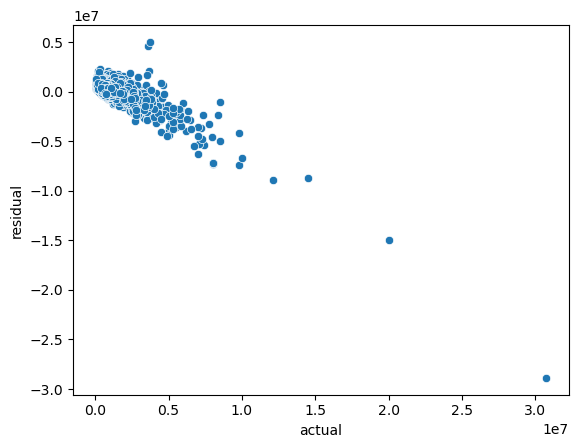

In [221]:
y_hat = results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1)
sns.scatterplot(x= y_test['price'],y= (y_hat - y_test)['price'].to_list()).set(xlabel='actual', ylabel='residual');

### RFE

In [ ]:
rfe = RFE(lm, n_features_to_select=)
rfe.fit()

## Log transformed Target

In [285]:
# Scale train and test feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log transform train and test target
log_y_train = np.log(y_train)

# y = training house prices, X = scaled training sqft_living
y = log_y_train
X = X_train_scaled

# fit model and display statistics
model = sm.OLS(y,sm.add_constant(X))
results = model.fit()
print_test_scores(X, y, X_test_scaled,log_y_test)
results.summary(xname=['const']+X_train.columns.to_list())

         Test R2: 0.41886919726729
Test Adjusted R2: 0.41886919726729


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     1479.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:08:09   Log-Likelihood:                -13730.
No. Observations:               22613   AIC:                         2.748e+04
Df Residuals:                   22601   BIC:                         2.758e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.7333      0.003   4649.274      0.000      13.728      13.739
bedrooms         -0.0609      0.004    -15.178      0.000      -0.069      -0.053
bathrooms         0.0878      0.005     16.418      0.000       0.077       0.098
sqft_living       0.2023      0.013     15.227      0.000       0.176       0.228
sqft_lot         -0.0020      0.003     -0.653      0.513      -0.008       0.004
floors            0.0503      0.004     12.170      0.000       0.042       0.058
sqft_above        0.1186      0.012      9.689      0.000       0.095       0.143
yr_built         -0.0823      0.004    -18.613      0.000      -0.091      -0.074
sqft_basement     0.0629      0.006     10.710      0.000       0.051       0.074
sqft_garage      -0.0015      0.004     -0.368      0.713      -0.009       0.006
sqft_patio        0.0362      0.003     10.967      0.000       0.030       0.043
yr_renovated      0.0099      0.003      3.196      0.001       0.004       0.016
==============================================================================
Omnibus:                     5101.212   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46698.803
Skew:                          -0.826   Prob(JB):                         0.00
Kurtosis:                       9.844   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residual Graph

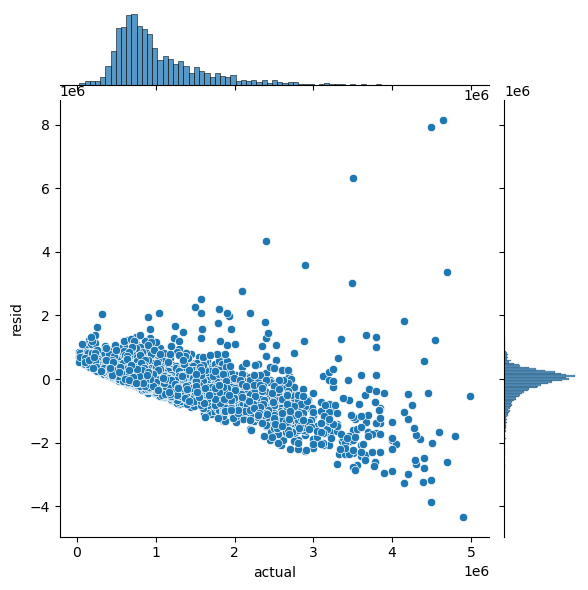

In [288]:
y_hat = np.exp(results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1))

y_df = pd.DataFrame({'hat':list(y_hat[0])}, index=range(y_hat.shape[0]))
y_df['actual'] = y_test['price'].to_list()
y_df['resid'] = (y_hat - y_test)['price'].to_list()

y_df = y_df.loc[y_df['resid'] < 13000000]
y_df = y_df.loc[y_df['actual'] < 5000000]

# sns.scatterplot(x= 'actual',y= 'resid', data=y_df).set(xlabel='actual', ylabel='residual')
sns.jointplot(x= 'actual',y= 'resid', data=y_df);

### VIF

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated,sqft_home
id,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,1969,0,1220
8910500230,920000.0,5,2.5,2770,6703,1.0,1950,0,3380
1180000275,311000.0,6,2.0,2880,6156,1.0,1956,0,3160
1604601802,775000.0,3,3.0,2160,1400,2.0,2010,0,2630
8562780790,592500.0,2,2.0,1120,758,2.0,2012,0,2250


In [281]:
# columns powerset, not including empty set
col_power_set = powerset(X_train.columns)
data = [X_train[subset] for subset in col_power_set]

labels = col_power_set
vif_df = pd.DataFrame(columns=)

for i, df_ in enumerate(data):
    print(labels[i])
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [VIF(df_.values, i) for i in range(df_.shape[1])]
    
    print(vif_data.sort_values(by='VIF', ascending=False), end='\n\n')

['bedrooms', 'sqft_living']
       feature       VIF
1  sqft_living  9.689216
0     bedrooms  9.689216

['bedrooms', 'sqft_lot']
    feature       VIF
1  sqft_lot  1.075462
0  bedrooms  1.075462

['bedrooms', 'floors']
    feature       VIF
0  bedrooms  6.280857
1    floors  6.280857

['bedrooms', 'sqft_above']
      feature      VIF
0    bedrooms  7.48246
1  sqft_above  7.48246

['bedrooms', 'yr_built']
    feature        VIF
0  bedrooms  13.373455
1  yr_built  13.373455

['bedrooms', 'sqft_basement']
         feature       VIF
0       bedrooms  1.772366
1  sqft_basement  1.772366

['bedrooms', 'sqft_garage']
       feature       VIF
0     bedrooms  2.614546
1  sqft_garage  2.614546

['bedrooms', 'sqft_patio']
      feature      VIF
1  sqft_patio  1.84058
0    bedrooms  1.84058

['bedrooms', 'yr_renovated']
        feature       VIF
1  yr_renovated  1.045419
0      bedrooms  1.045419

['bathrooms', 'sqft_living']
       feature        VIF
0    bathrooms  14.101002
1  sqft_living  14.1

### all Combinations of numeric Features

In [337]:
# columns powerset, not including empty set
all_cols = X_train.columns.to_list()
num_cols = X_train.shape[1]
col_power_set = powerset(X_train.columns)
n = len(col_power_set)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(data=scaler.transform(X_train), columns=all_cols)
# X_test = pd.DataFrame(data=scaler.transform(X_test), columns=all_cols)
X_train, X_test = scale_custom(X_train,X_test,['yr_renovated'])

data_train = [X_train[subset] for subset in col_power_set]
data_test = [X_test[subset] for subset in col_power_set]
labels = col_power_set
ytrain, ytest = np.log(y_train.values), np.log(y_test.values)

feat_combs_df = pd.DataFrame(columns=['cols','train_R2','train_R2_adj','test_R2','test_R2_adj']+all_cols)

for i, data in enumerate(zip(data_train,data_test)):
    print(i, '/', n, end='\r')
    xtrain, xtest = data[0], data[1]
    train_R2 = get_train_score(xtrain,ytrain)
    train_R2_adj = get_adjusted_train_score(xtrain,ytrain)
    test_R2 = get_test_score(xtrain,ytrain,xtest,ytest)
    test_R2_adj = get_adjusted_test_score(xtrain,ytrain,xtest,ytest)

    feature_vifs = [np.nan for _ in range(num_cols)]
    used_col_iter = 0
    cols_used = xtrain.columns.to_list()
    num_cols_used = len(cols_used)
    for j in range(num_cols):
        if cols_used[used_col_iter] == all_cols[j]:
            feature_vifs[j] = VIF(xtrain.values, used_col_iter)
            used_col_iter += 1
            if used_col_iter >= num_cols_used:
                break

    feat_combs_df.loc[i] = [labels[i], train_R2, train_R2_adj, test_R2, test_R2_adj] + feature_vifs



In [312]:
feat_combs_df.sort_values(by='test_R2_adj', ascending=False)

,cols,train_R2,train_R2_adj,test_R2,test_R2_adj
1991,"[bedrooms, bathrooms, sqft_living, floors, sqf...",0.418458,0.418201,0.419024,0.418252
1839,"[bedrooms, bathrooms, sqft_living, floors, sqf...",0.418195,0.417963,0.418938,0.418243
2030,"[bedrooms, bathrooms, sqft_living, floors, sqf...",0.418462,0.418179,0.419068,0.418219
1989,"[bedrooms, bathrooms, sqft_living, floors, sqf...",0.418199,0.417942,0.418988,0.418217
2025,"[bedrooms, bathrooms, sqft_living, sqft_lot, f...",0.418470,0.418187,0.418824,0.417975
...,...,...,...,...,...
34,"[floors, yr_built]",0.054765,0.054640,0.053970,0.053593
177,"[sqft_lot, yr_built, yr_renovated]",0.032388,0.032217,0.034719,0.034207
47,"[yr_built, yr_renovated]",0.025972,0.025842,0.026691,0.026303
28,"[sqft_lot, yr_built]",0.021154,0.021025,0.022427,0.022038


# Categorical correlations to Price

In [47]:
cat_df = df.select_dtypes(object)
cat_df['renovated'] = numeric_df['yr_renovated'].map(lambda x: 0 if x == 0 else 1)
cat_df['has_basement'] = numeric_df['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
cat_df['has_garage'] = numeric_df['sqft_garage'].map(lambda x: 0 if x == 0 else 1)
cat_df['has_patio'] = numeric_df['sqft_patio'].map(lambda x: 0 if x == 0 else 1)
display(cat_df.info())
cat_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30152 entries, 7399300360 to 9557800100
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          30152 non-null  object 
 1   waterfront    30152 non-null  object 
 2   greenbelt     30152 non-null  object 
 3   nuisance      30152 non-null  object 
 4   view          30152 non-null  object 
 5   condition     30152 non-null  object 
 6   grade         30152 non-null  object 
 7   heat_source   30120 non-null  object 
 8   sewer_system  30138 non-null  object 
 9   address       30152 non-null  object 
 10  renovated     30151 non-null  float64
 11  has_basement  30151 non-null  float64
 12  has_garage    30151 non-null  float64
 13  has_patio     30151 non-null  float64
dtypes: float64(4), object(10)
memory usage: 4.5+ MB


None

,date,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,address,renovated,has_basement,has_garage,has_patio
id,,,,,,,,,,,,,,
7399300360,5/24/2022,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,"2102 Southeast 21st Court, Renton, Washington ...",0.0,0.0,0.0,1.0
8910500230,12/13/2021,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,"11231 Greenwood Avenue North, Seattle, Washing...",0.0,1.0,0.0,1.0
1180000275,9/29/2021,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,"8504 South 113th Street, Seattle, Washington 9...",0.0,1.0,0.0,0.0
1604601802,12/14/2021,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,"4079 Letitia Avenue South, Seattle, Washington...",0.0,1.0,1.0,1.0
8562780790,8/24/2021,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,"2193 Northwest Talus Drive, Issaquah, Washingt...",0.0,1.0,1.0,1.0


In [48]:
# cleaning categorical features
zips = []
street_name = []

# make the address data useable
for i in cat_df["address"]:
    # create variable to store partitioned strings from address column
    # first will be used in certain iterations
    info = i.split(",")
    first = info[0].split(" ")

    # store variables in appropriate lists
    zips.append(info[-2][-5:])
    street_name.append(" ".join(first[1:len(first)]))

# create columns from the lists in the cat_df
cat_df["zipcode"] = zips
cat_df["street_name"] = street_name

# remove zips codes outside King County
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = [x.split()[0] for x in ci_zips]
cat_df = cat_df.loc[[(i in ci_zips) for i in cat_df['zipcode'].values]]

#remove irrelevant features
cat_df.drop(columns=['date', 'address'], inplace=True)

# drop
cat_df.dropna(inplace=True)

cat_df


,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,renovated,has_basement,has_garage,has_patio,zipcode,street_name
id,,,,,,,,,,,,,,
7399300360,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,0.0,0.0,0.0,1.0,98055,Southeast 21st Court
8910500230,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,0.0,1.0,0.0,1.0,98133,Greenwood Avenue North
1180000275,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,0.0,1.0,0.0,0.0,98178,South 113th Street
1604601802,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,0.0,1.0,1.0,1.0,98118,Letitia Avenue South
8562780790,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,0.0,1.0,1.0,1.0,98027,Northwest Talus Drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7834800180,NO,NO,NO,NONE,Good,8 Good,Oil,PUBLIC,0.0,1.0,0.0,1.0,98103,Eastern Avenue North
194000695,NO,NO,NO,FAIR,Average,7 Average,Gas,PUBLIC,0.0,0.0,0.0,1.0,98116,44th Avenue Southwest
7960100080,NO,NO,YES,NONE,Average,7 Average,Gas,PUBLIC,0.0,1.0,1.0,1.0,98122,Martin Luther King Jr Way


In [37]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_data = encoder.fit_transform(cat_df)
one_hot_df = pd.DataFrame(data=encoded_data, columns=encoder.get_feature_names())
one_hot_df

,x0_YES,x1_YES,x2_YES,x3_EXCELLENT,x3_FAIR,x3_GOOD,x3_NONE,x4_Fair,x4_Good,x4_Poor,...,x13_Wright Avenue Southwest,x13_Wynalda Drive,x13_Yakima Ave S,x13_Yakima Avenue South,x13_Yakima Place Southeast,x13_Yale Ave E,x13_Yale Avenue East,x13_Zemp Way,x13_Zillah Place Southeast,x13_Zurs Strasse
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29142,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29143,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29144,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29145,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Combined data

In [8]:
cat_cols = ['has_basement', 'has_garage', 'has_patio', 'renovated']
combined_df = numeric_df.merge(cat_df[cat_cols], 
                               how='inner',
                               left_on=numeric_df.index, 
                               right_on=cat_df.index).set_index('key_0')
combined_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_home,sqft_basement,sqft_garage,sqft_patio,yr_renovated,has_basement,has_garage,has_patio,renovated
key_0,,,,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,1180,1969,1220,0,0,40,0,0.0,0.0,1.0,0.0
8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1950,3380,1570,0,240,0,1.0,0.0,1.0,0.0
1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1956,3160,1580,0,0,0,1.0,0.0,0.0,0.0
1604601802,775000.0,3,3.0,2160,1400,2.0,1090,2010,2630,1070,200,270,0,1.0,1.0,1.0,0.0
8562780790,592500.0,2,2.0,1120,758,2.0,1120,2012,2250,550,550,30,0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7834800180,1555000.0,5,2.0,1910,4000,1.5,1600,1921,2940,1130,0,210,0,1.0,0.0,1.0,0.0
194000695,1313000.0,3,2.0,2020,5800,2.0,2020,2011,2540,0,0,520,0,0.0,0.0,1.0,0.0
7960100080,800000.0,3,2.0,1620,3600,1.0,940,1995,2210,920,240,110,0,1.0,1.0,1.0,0.0


### Train - Test Split

In [9]:
# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(combined_df.drop(columns='price'), combined_df[['price']], test_size=.25, random_state=42)


### custom scaling

In [10]:
numeric_xtrain, numeric_xtest = scale_custom(X_train.drop(columns=cat_cols), X_test.drop(columns=cat_cols), bad_cols)
X_train = numeric_xtrain.join(X_train[cat_cols],
                              how='inner')
X_test = numeric_xtest.join(X_test[cat_cols],
                            how='inner')

# brendan

In [197]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
# display(df.head())
# print("Deleted Duplicate Entries:")
# display(df.loc[df.duplicated(keep=False)])
df.drop_duplicates(inplace=True)

In [198]:
# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), df[['price']], test_size=.25, random_state=42)


In [199]:
# Ordinal Encoding
oe_cols = ['view', 'condition', 'grade']
oe_orders = [['NONE','FAIR','AVERAGE','GOOD','EXCELLENT'],
             ['Poor','Fair','Average','Good','Very Good'],
             ['1 Cabin',
              '2 Substandard',
              '3 Poor',
              '4 Low',
              '5 Fair',
              '6 Low Average',
              '7 Average',
              '8 Good',
              '9 Better',
              '10 Very Good',
              '11 Excellent',
              '12 Luxury',
              '13 Mansion']]

for col, order in zip(oe_cols,oe_orders):
    oe = OrdinalEncoder([order]).fit(X_train[[col]])
    X_train[col] = oe.transform(X_train[[col]])
    X_test[col] = oe.transform(X_test[[col]])



In [200]:
# label Encoding
le_cols = ['waterfront', 'greenbelt', 'nuisance']

for col in le_cols:
    le = LabelEncoder().fit(X_train[[col]])
    X_train[col] = le.transform(X_train[[col]])
    X_test[col] = le.transform(X_test[[col]])

In [201]:
# setting up zipcode column

# King County Zipcodes
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = set([x.split()[0] for x in ci_zips])

X_train['zipcode'] = [address.split(',')[-2][-5:] for address in X_train['address']]
X_train['zipcode'] = X_train['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

X_test['zipcode'] = [address.split(',')[-2][-5:] for address in X_test['address']]
X_test['zipcode'] = X_test['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

# drop rows outside King county
old_idxs = set(X_train.index)
X_train.dropna(inplace=True)
y_train.drop(index= old_idxs - set(X_train.index), inplace=True)

old_idxs = set(X_test.index)
X_test.dropna(inplace=True)
y_test.drop(index= old_idxs - set(X_test.index), inplace=True)

# setting up streetname column
X_train['street_name'] = [address.split(',')[0] for address in X_train['address']]
X_test['street_name'] = [address.split(',')[0] for address in X_test['address']]


In [202]:
ohe_cols = ['heat_source','sewer_system','zipcode']

ohe = OneHotEncoder(sparse = False, drop='first')
train_ohe_df = ohe.fit_transform(X_train[['heat_source','sewer_system','zipcode']])
train_ohe_df = pd.DataFrame(train_ohe_df, columns = ohe.get_feature_names(), index = X_train.index)
train_ohe_df

test_ohe_df = ohe.transform(X_test[['heat_source','sewer_system','zipcode']])
test_ohe_df = pd.DataFrame(test_ohe_df, columns = ohe.get_feature_names(), index = X_test.index)

In [205]:
numeric_cols = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'sqft_above',
                'yr_built',
                'sqft_basement',
                'sqft_garage',
                'sqft_patio',
                'yr_renovated']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [208]:
model_cols = ['bedrooms',
              'bathrooms',
              'sqft_living',
              'sqft_lot',
              'floors',
              'sqft_above',
              'yr_built',
              'sqft_basement',
              'sqft_garage',
              'sqft_patio',
              'yr_renovated',
              'waterfront',
              'greenbelt',
              'nuisance',
              'view',
              'condition',
              'grade']

X_train = X_train[model_cols]
X_train = pd.concat([X_train, train_ohe_df], 1)

X_test = X_test[model_cols]
X_test = pd.concat([X_test, test_ohe_df], 1)


In [211]:
# sklearn
lr = lm.LinearRegression()
lr.fit(X_train,y_train)
print("Train R2:", get_train_score(X_train, y_train))
print("Train Adjusted R2:", get_adjusted_train_score(X_train, y_train))
print_test_scores(X_train, y_train, X_test, y_test)

# statsmodel
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()
results.summary()

Train R2: 0.638442813410385
Train Adjusted R2: 0.636747936208669
         Test R2: 0.7194529792307822
Test Adjusted R2: 0.7194529792307822


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     380.4
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:23:24   Log-Likelihood:            -3.1977e+05
No. Observations:               21862   AIC:                         6.397e+05
Df Residuals:                   21760   BIC:                         6.405e+05
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.137e+05    4.9e+04     -4.359      0.000    -3.1e+05   -1.18e+05
bedrooms              -6.936e+04   5155.567    -13.454      0.000   -7.95e+04   -5.93e+04
bathrooms              3.769e+04   6872.239      5.485      0.000    2.42e+04    5.12e+04
sqft_living            1.279e+05    1.7e+04      7.519      0.000    9.46e+04    1.61e+05
sqft_lot               3.462e+04   4058.751      8.530      0.000    2.67e+04    4.26e+04
floors                -7.886e+04   5840.336    -13.502      0.000   -9.03e+04   -6.74e+04
sqft_above             2.715e+05   1.57e+04     17.303      0.000    2.41e+05    3.02e+05
yr_built              -1.644e+04   6652.431     -2.471      0.013   -2.95e+04   -3395.912
sqft_basement          4.039e+04   7786.166      5.188      0.000    2.51e+04    5.57e+04
sqft_garage           -3871.3606   5489.245     -0.705      0.481   -1.46e+04    6887.961
sqft_patio             1.954e+04   4285.605      4.560      0.000    1.11e+04    2.79e+04
yr_renovated           9463.9889   4032.025      2.347      0.019    1560.925    1.74e+04
waterfront             1.059e+06   3.24e+04     32.712      0.000    9.95e+05    1.12e+06
greenbelt               3.89e+04   2.36e+04      1.651      0.099   -7275.638    8.51e+04
nuisance              -4.028e+04   1.02e+04     -3.967      0.000   -6.02e+04   -2.04e+04
view                   1.025e+05   5261.856     19.485      0.000    9.22e+04    1.13e+05
condition              4.492e+04   5974.058      7.520      0.000    3.32e+04    5.66e+04
grade                  1.105e+05   6033.351     18.313      0.000    9.87e+04    1.22e+05
x0_Electricity/Solar  -6.758e+04   8.42e+04     -0.803      0.422   -2.33e+05    9.74e+04
x0_Gas                -2.719e+04   1.02e+04     -2.658      0.008   -4.72e+04   -7137.513
x0_Gas/Solar           1.366e+05   6.57e+04      2.079      0.038    7811.290    2.65e+05
x0_Oil                -6.151e+04   1.55e+04     -3.973      0.000   -9.18e+04   -3.12e+04
x0_Oil/Solar            5.49e+04   3.87e+05      0.142      0.887   -7.03e+05    8.13e+05
x0_Other               2.551e+04    1.3e+05      0.196      0.844   -2.29e+05     2.8e+05
x1_PRIVATE RESTRICTED -2.881e+05   2.45e+05     -1.175      0.240   -7.69e+05    1.93e+05
x1_PUBLIC              6.477e+04   1.36e+04      4.752      0.000    3.81e+04    9.15e+04
x1_PUBLIC RESTRICTED  -7.558e+04   5.47e+05     -0.138      0.890   -1.15e+06    9.96e+05
x2_98002               9.628e+04   4.18e+04      2.302      0.021    1.43e+04    1.78e+05
x2_98003               2.388e+04   3.97e+04      0.602      0.547   -5.39e+04    1.02e+05
x2_98004                2.23e+06   4.42e+04     50.437      0.000    2.14e+06    2.32e+06
x2_98005               1.033e+06   5.44e+04     18.990      0.000    9.26e+05    1.14e+06
x2_98006               

In [212]:
y_train = np.log(y_train)
y_test = np.log(y_test)

# sklearn
lr = lm.LinearRegression()
lr.fit(X_train,y_train)
print("Train R2:", get_train_score(X_train, y_train))
print("Train Adjusted R2:", get_adjusted_train_score(X_train, y_train))
print_test_scores(X_train, y_train, X_test, y_test)

# statsmodel
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()
results.summary()

Train R2: 0.7003132747833027
Train Adjusted R2: 0.6989084286979081
         Test R2: 0.723192856387171
Test Adjusted R2: 0.723192856387171


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     503.5
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:23:27   Log-Likelihood:                -6116.0
No. Observations:               21862   AIC:                         1.244e+04
Df Residuals:                   21760   BIC:                         1.325e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.5568      0.029    435.684      0.000      12.500      12.613
bedrooms                  0.0079      0.003      2.615      0.009       0.002       0.014
bathrooms                 0.0243      0.004      6.026      0.000       0.016       0.032
sqft_living               0.0864      0.010      8.633      0.000       0.067       0.106
sqft_lot                  0.0300      0.002     12.558      0.000       0.025       0.035
floors                   -0.0206      0.003     -6.005      0.000      -0.027      -0.014
sqft_above                0.1073      0.009     11.628      0.000       0.089       0.125
yr_built                 -0.0045      0.004     -1.146      0.252      -0.012       0.003
sqft_basement             0.0093      0.005      2.039      0.041       0.000       0.018
sqft_garage               0.0147      0.003      4.570      0.000       0.008       0.021
sqft_patio                0.0113      0.003      4.472      0.000       0.006       0.016
yr_renovated              0.0148      0.002      6.257      0.000       0.010       0.019
waterfront                0.2666      0.019     14.008      0.000       0.229       0.304
greenbelt                 0.0518      0.014      3.737      0.000       0.025       0.079
nuisance                 -0.0478      0.006     -8.014      0.000      -0.060      -0.036
view                      0.0639      0.003     20.659      0.000       0.058       0.070
condition                 0.0619      0.004     17.616      0.000       0.055       0.069
grade                     0.0842      0.004     23.737      0.000       0.077       0.091
x0_Electricity/Solar     -0.2036      0.049     -4.115      0.000      -0.301      -0.107
x0_Gas                    0.0214      0.006      3.553      0.000       0.010       0.033
x0_Gas/Solar              0.0598      0.039      1.548      0.122      -0.016       0.136
x0_Oil                    0.0090      0.009      0.988      0.323      -0.009       0.027
x0_Oil/Solar              0.2179      0.227      0.959      0.338      -0.228       0.663
x0_Other                  0.0914      0.076      1.197      0.231      -0.058       0.241
x1_PRIVATE RESTRICTED    -0.5995      0.144     -4.157      0.000      -0.882      -0.317
x1_PUBLIC                 0.0181      0.008      2.253      0.024       0.002       0.034
x1_PUBLIC RESTRICTED      0.2617      0.321      0.814      0.416      -0.368       0.892
x2_98002                 -0.0779      0.025     -3.169      0.002      -0.126      -0.030
x2_98003                 -0.0334      0.023     -1.430      0.153      -0.079       0.012
x2_98004                  1.1795      0.026     45.373      0.000       1.129       1.230
x2_98005                  0.8832      0.032     27.617      0.000       0.821       0.946
x2_98006               

In [220]:
corr_df['bathrooms'].sort_values(ascending=False)

bathrooms      1.000000
sqft_living    0.775412
sqft_above     0.678796
grade          0.653208
bedrooms       0.595202
                 ...   
x2_98014       0.002072
x2_98042       0.002042
x2_98055       0.001886
x2_98023       0.001635
x2_98177       0.001188
Name: bathrooms, Length: 101, dtype: float64

In [234]:
corr_df = X_train.corr().abs()
count = 0
top_corrs = pd.DataFrame(columns=['corr','index','col'])
for index in corr_df.index:
    for col in corr_df.columns:
        if corr_df.loc[index,col] > .3 and corr_df.loc[index,col] != 1:
            top_corrs.loc[top_corrs.shape[0]+1] = [corr_df.loc[index,col], index, col]
            count += 1
print(count)

70


In [246]:
numeric_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'yr_built',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_renovated']

In [258]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    # display(top_corrs.sort_values(by='corr', ascending=False))
    display(top_corrs.groupby('index').count().sort_values(by='col', ascending=False))
    display(top_corrs.groupby('index').mean().sort_values(by='corr', ascending=False))


,corr,col
index,,
sqft_living,9,9
grade,8,8
sqft_above,8,8
bathrooms,8,8
yr_built,8,8
sqft_garage,6,6
floors,5,5
bedrooms,5,5
sqft_patio,4,4


,corr
index,
sqft_above,0.579672
sqft_living,0.551300
bathrooms,0.548666
grade,0.540655
x0_Gas,0.500221
bedrooms,0.490857
sqft_garage,0.473040
floors,0.461176
view,0.425773


# Scraping


In [60]:
import requests
import pandas as pd

with open("/Users/alexanderdaffara/Documents/api_info/google_maps_api_key.txt", "r") as f:
    api_key = f.read()

def get_zip_codes(df):
    # Make a request to the Google Maps API using the latitude and longitude values
    url = f"https://maps.googleapis.com/maps/api/geocode/json?latlng={latitude},{longitude}&key={api_key}"
    response = requests.get(url)
    response_json = response.json()

    # Extract the zip code from the response
    zip_code = None
    for result in response_json['results']:
        for component in result['address_components']:
            if 'postal_code' in component['types']:
                zip_code = component['long_name']
                break

    return zip_code

# zip_codes = get_zip_codes(df)


KeyboardInterrupt: 